# Lab 1, Question 8

In [28]:
# Install the geemap package (only needs to be run once, uncomment below and run it the first time you run this notebook in a session).
# !pip install geemap

In [29]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    EE_PROJECT_ID = userdata.get('EE_PROJECT_ID') 
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()  # take environment variables
    EE_PROJECT_ID = os.getenv('EE_PROJECT_ID')

In [30]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project=EE_PROJECT_ID)
import geemap

### (8) Using Sentinel 2, create a figure that does the following over the city of Christchurch, NZ:
*   Conduct a basic quality assessment of the data you use, using a cloudy pixel % estimate.
* Describe/show the spectral reflectance signatures of: urban, forest, grassland, water and bare soil.
* Illustrates the sample areas that you have used to create these spectral signatures.

Provide a publication quality copy of this figure in the answer proforma. Publication quality means that:  
1.   It is at a good quality (resolution) and not blurry.
2.   The font size of all elements is big enough to read easily on a screen when placed in the document.
3. Has a figure caption that ensures the reader knows what you have done and why.
4. Tells the story 'at a glance'. Don't make your viewer work too hard to understand your core message.

(25 pts)




In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import urllib.request
import tempfile
import matplotlib.image as mpimg

### Step 1: Cloud Masking using QA60

Define Point expanded ROI

In [32]:
# Christchurch Botanic Gardens
christchurch_coordinates = [172.6404335, -43.523777]
roi_point = ee.Geometry.Point(christchurch_coordinates)

# Define a region for fetching the image thumbnail
# roi = roi_point.buffer(1500).bounds()
expanded_roi = roi_point.buffer(7500).bounds()  # box for image preview

Load Image with least cloud in the year of 2024

In [33]:
# # Load Sentinel-2 L2A collection for a summer month
# # Using a recent summer for good vegetation and sun angle
s2_collection = 'COPERNICUS/S2_SR_HARMONIZED'
from_date = '2024-01-01'
to_date = '2024-12-31'

# # Test masked map on more cloudy day
# roi_cloud_img = ee.ImageCollection(s2_collection) \
#     .filterBounds(roi_point) \
#     .filterDate(from_date, to_date) \
#     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
#     .sort('CLOUDY_PIXEL_PERCENTAGE', ascending=False) \
#     .first()

roi_cloud_img = ee.ImageCollection(s2_collection) \
    .filterBounds(roi_point) \
    .filterDate(from_date, to_date) \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first()

print('Image ID:', roi_cloud_img.get('PRODUCT_ID').getInfo())
print('Cloud Cover (whole scene):', roi_cloud_img.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())
print('Over Land Cloud Cover (whole scene):', roi_cloud_img.get('CLOUDY_PIXEL_OVER_LAND_PERCENTAGE').getInfo())

Image ID: S2A_MSIL2A_20240904T222541_N0511_R029_T59GPM_20240905T020950
Cloud Cover (whole scene): 0.000717
Over Land Cloud Cover (whole scene): 0.000497


Display the image to have a look

In [34]:
from IPython.display import Image
# Get RGB thumbnail of Christchurch
thumb_params = {
    # 'dimensions': 512,
    'region': expanded_roi,
    'format': 'png',
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1
}
roi_url = roi_cloud_img.getThumbURL(thumb_params)

Image(url= roi_url)

Cloud masking

In [35]:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
def mask_s2_clouds(image):
    # Cloud mask. Masked out between 2022-01-25 to 2024-02-28 inclusive.
    # QA60 band is Cloud mask
    qa = image.select('QA60')

    # Bitmask
    #   Bit 10: Opaque clouds
    #     0: No opaque clouds
    #     1: Opaque clouds present
    #   Bit 11: Cirrus clouds
    #     0: No cirrus clouds
    #     1: Cirrus clouds present
    mask = qa.bitwiseAnd(1 << 10).eq(0) \
        .And(qa.bitwiseAnd(1 << 11).eq(0))

    # The assets contain 12 UINT16 spectral bands representing SR scaled by 10000
    return image.updateMask(mask).divide(10000)

# Apply the cloud mask
roi_cloud_masked_img = mask_s2_clouds(roi_cloud_img)

Show the map to have a look

In [36]:
vis_params_true_color = {
    'bands': ['B4', 'B3', 'B2'], # Red, Green, Blue bands
    'min': 0,
    'max': 3000, # Max reflectance value for stretching
    'gamma': 1.4
}
vis_params_masked = {**vis_params_true_color, 'max': 0.3}

roi_map = geemap.Map(center=christchurch_coordinates[::-1], zoom=12)
roi_map.addLayer(roi_cloud_img, vis_params_true_color, 'True Colour Image (Cloudy)')
roi_map.addLayer(roi_cloud_masked_img, vis_params_masked, 'Cloud Masked')
roi_map.add_marker(location=[-43.451378, 172.686880])
roi_map

Map(center=[-43.523777, 172.6404335], controls=(WidgetControl(options=['position', 'transparent_bg'], position…

`get_reflectances` from Sentinent-2 bands and `get_region_coords` function

In [37]:
s2_band_names = {
    'B1': '443.9nm - Aerosols', # 60 meters	443.9nm (S2A) / 442.3nm (S2B)
    'B2': '496.6nm - Blue', # 10 meters	496.6nm (S2A) / 492.1nm (S2B)
    'B3': '560nm - Green', # 10 meters	560nm (S2A) / 559nm (S2B)
    'B4': '664.5nm - Red', # 10 meters	664.5nm (S2A) / 665nm (S2B)
    'B5': '703.9nm - Red Edge 1', # 20 meters	703.9nm (S2A) / 703.8nm (S2B)
    'B6': '740.2nm - Red Edge 2', # 20 meters	740.2nm (S2A) / 739.1nm (S2B)
    'B7': '782.5nm - Red Edge 3', # 20 meters	782.5nm (S2A) / 779.7nm (S2B)
    'B8': '835.1nm - NIR', # 10 meters	835.1nm (S2A) / 833nm (S2B)
    'B8A': '864.8nm - Red Edge 4', # 20 meters	864.8nm (S2A) / 864nm (S2B)
    'B9': '945nm - Water vapor', # 60 meters	945nm (S2A) / 943.2nm (S2B)
    'B11': '1613.7nm - SWIR 1', # 20 meters	1613.7nm (S2A) / 1610.4nm (S2B)
    'B12': '2202.4nm - SWIR 2', # 20 meters	2202.4nm (S2A) / 2185.7nm (S2B)
}

# Get coordinates of regions
def get_region_coords(region):
    coords = region.coordinates().getInfo()[0]
    lons = [pt[0] for pt in coords]
    lats = [pt[1] for pt in coords]
    return min(lons), max(lons), min(lats), max(lats)



def get_reflectances(region, from_date, to_date):
  # Load surface reflectance image
  image = ee.ImageCollection(s2_collection) \
      .filterBounds(region) \
      .filterDate(from_date, to_date) \
      .sort('CLOUD_COVER') \
      .first()

  # sentinels.copernicus.eu/documents/247904/685211/Sentinel-2_User_Handbook
  # Define bands and scaling
  bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
           'B8', 'B8A', 'B9', 'B11', 'B12']
  scale_factor = 0.0001

  # Calculate mean reflectance
  mean_dict = image.select(bands).reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=region,
      scale=10,
      maxPixels=1e9).getInfo()

  return [mean_dict[b] * scale_factor for b in bands]

Define region of interested surface types

In [38]:
urban = [-43.538735, 172.636655]
forest = [-43.465786, 172.693103]
grassland = [-43.524488, 172.625256]
water = [-43.528381, 172.710064]
bare_soil = [-43.586269, 172.635050] # Cannot find a good bare soil area

coordinates = [urban, forest, grassland, water, bare_soil]
surfaces = ['urban', 'forest', 'grassland', 'water', 'bare_soil']

rois = {}

for idx, surface in enumerate(surfaces):
  point = ee.Geometry.Point(coordinates[idx][::-1])
  region = point.buffer(150).bounds()
  rois[surface] = {
      'region': region, # 300 m box
      'reflectance': get_reflectances(region, from_date, to_date),
      'coords': get_region_coords(region)
  }

Combine all rois on map and their reflectances plot

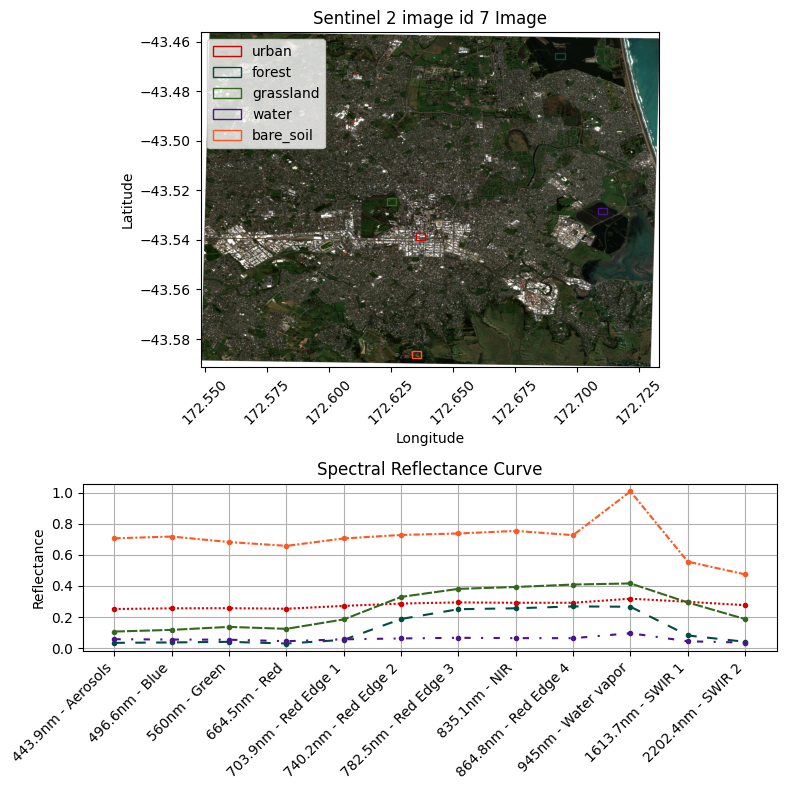

In [39]:
# Ploting all rois
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

colors = ['#D50000', '#004D40', '#33691E', '#4A148C', '#FF5722']
markers = ['.', 'd', '*', 's', 'v']
lines = [
    (0, (1, 1)),
    (0, (5, 5)),
    (0, (5, 1)),
    (0, (3, 5, 1, 5)),
    (0, (3, 1, 1, 1))]

# Load and plot image with annotation
with tempfile.NamedTemporaryFile(suffix=".png") as f:
    xmin, xmax, ymin, ymax = get_region_coords(expanded_roi)
    urllib.request.urlretrieve(roi_url, f.name)
    img = mpimg.imread(f.name)
    ax1.imshow(img, extent=[xmin, xmax, ymin, ymax])
    ax1.set_title("Sentinel 2 image id 7 Image")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    # Add red rectangle for region of interest
    for idx, surface in enumerate(surfaces):
      rxmin, rxmax, rymin, rymax = rois[surface]['coords']
      width = rxmax - rxmin
      height = rymax - rymin
      rect = patches.Rectangle((rxmin, rymin), width, height,
                              linewidth=1, edgecolor=colors[idx], facecolor='none')
      ax1.add_patch(rect)
      ax1.set_xlabel("Longitude")
      ax1.tick_params(axis='x', labelrotation=45)
      ax1.set_ylabel("Latitude")

# Plot reflectance
s2_labels = list(s2_band_names.values())
for idx, surface in enumerate(surfaces):
    region = rois[surface]['region']
    reflectance = rois[surface]['reflectance']
    l2, = ax2.plot(s2_labels, reflectance,
             color=colors[idx], linestyle=lines[idx], marker='.')
ax2.set_ylabel("Reflectance")
ax2.grid(True)
ax2.set_title("Spectral Reflectance Curve")
ax2.set_xticks(range(len(s2_labels)))
ax2.set_xticklabels(s2_labels, rotation=45, ha='right')
ax1.legend(surfaces)

plt.tight_layout()
plt.show()